Step 1: User Segmentation via K-means Clustering
This step performs unsupervised clustering on aggregated user transaction behavior to identify distinct user segments for targeted insights or actions.

Input Data
    Aggregated per-user features computed across all Level 2 processed files:

        avg_amount: Average transaction amount per user

        txn_count: Number of transactions per user

        avg_risk_score: Average risk score per user

        fraud_rate: Fraction of user’s transactions flagged as fraud

        avg_recency: Average time (seconds) between user transactions

Processing
    Features scaled using StandardScaler

    Optimal cluster count estimated using Elbow Method (plot of inertia vs. number of clusters)

    Final K-means clustering performed with k=4 clusters

    Cluster assignments added to user data

Outputs
    Summary statistics of features by cluster to characterize user groups

    2D PCA visualization of user segments showing cluster separation

Insights
    Clusters reveal natural groupings of users based on transaction volume, risk, fraud likelihood, and recency behavior

    Enables targeted fraud monitoring and personalized marketing or risk management strategies

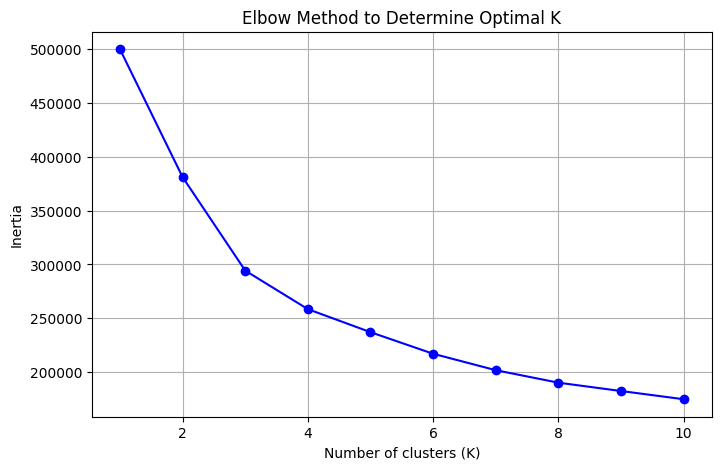


Cluster statistics:

         avg_amount   txn_count  avg_risk_score  fraud_rate  avg_recency
cluster                                                                 
0         68.071722  555.783659       24.782035    0.023497  4267.866944
1         64.153357  529.038125       24.268587    0.018449  4463.933561
2         72.711481  528.596443       25.297728    0.029575  4477.779834
3         67.792943  502.732633       24.756395    0.023042  4690.403566


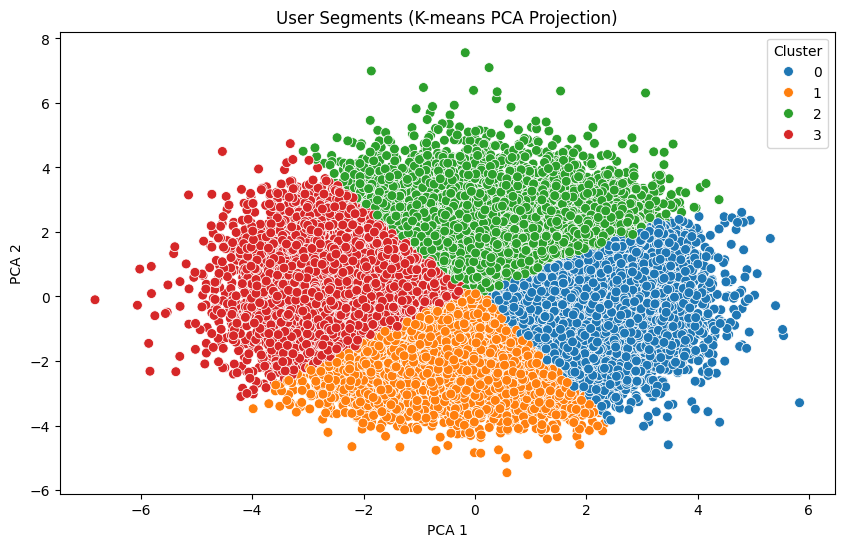

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

UPDATED_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data"
files = [f for f in os.listdir(UPDATED_DIR) if f.endswith("_cleaned_level2.csv")]

# Dictionary to accumulate per-user aggregates across files
user_agg = {}

def merge_user_aggregates(existing, new):
    """
    Merge two user aggregates dicts by user_id.
    existing and new are dicts:
      {user_id: {'amount_sum': float, 'txn_count': int, 'risk_sum': float,
                 'fraud_sum': float, 'recency_sum': float}}
    """
    for user, vals in new.items():
        if user in existing:
            existing[user]['amount_sum'] += vals['amount_sum']
            existing[user]['txn_count'] += vals['txn_count']
            existing[user]['risk_sum'] += vals['risk_sum']
            existing[user]['fraud_sum'] += vals['fraud_sum']
            existing[user]['recency_sum'] += vals['recency_sum']
        else:
            existing[user] = vals
    return existing

for file in files:
    try:
        path = os.path.join(UPDATED_DIR, file)
        df = pd.read_csv(path)

        # Convert fraud_flag to numeric if boolean or object
        if df['fraud_flag'].dtype == 'bool':
            df['fraud_flag'] = df['fraud_flag'].astype(int)
        elif df['fraud_flag'].dtype == 'object':
            df['fraud_flag'] = df['fraud_flag'].map({'True':1, 'False':0}).fillna(0).astype(int)

        # Fill missing recency_seconds with 0
        df['recency_seconds'] = pd.to_numeric(df['recency_seconds'], errors='coerce').fillna(0)

        # Aggregate per user in current file
        agg = df.groupby('user_id').agg(
            amount_sum=('amount', 'sum'),
            txn_count=('amount', 'count'),
            risk_sum=('risk_score', 'sum'),
            fraud_sum=('fraud_flag', 'sum'),
            recency_sum=('recency_seconds', 'sum')
        ).to_dict(orient='index')

        # Merge current file user aggregates with accumulated ones
        user_agg = merge_user_aggregates(user_agg, agg)

    except Exception as e:
        print(f"Skipped {file} due to error: {e}")

# After processing all files, build final dataframe from user_agg
user_df = pd.DataFrame.from_dict(user_agg, orient='index').reset_index().rename(columns={'index': 'user_id'})

# Calculate average features per user
user_df['avg_amount'] = user_df['amount_sum'] / user_df['txn_count']
user_df['avg_risk_score'] = user_df['risk_sum'] / user_df['txn_count']
user_df['fraud_rate'] = user_df['fraud_sum'] / user_df['txn_count']
user_df['avg_recency'] = user_df['recency_sum'] / user_df['txn_count']

# Keep features for clustering
features = ['avg_amount', 'txn_count', 'avg_risk_score', 'fraud_rate', 'avg_recency']
X = user_df[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method for k
inertia = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.grid(True)
plt.show()

# Choose optimal k (adjust based on elbow plot)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_df['cluster'] = kmeans.fit_predict(X_scaled)

print("\nCluster statistics:\n")
print(user_df.groupby('cluster')[features].mean())

# PCA plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=user_df['cluster'], palette='tab10', s=50)
plt.title('User Segments (K-means PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()


Step 2: Transaction Amount Prediction Using Linear Regression
This step builds and evaluates a regression model to predict transaction amounts based on user and transaction features.

Input Data
    Combined transactions from all Level 2 processed files with features including:

        Time features: hour, day_of_week

        Risk-related: risk_score, recency_seconds, fraud_flag

        Categorical: merchant_category, currency, device_type, location_country, status, is_online

        Target variable: amount (transaction value)

Processing
    Incremental loading of data with memory efficiency

    Feature extraction and cleaning (dropping rows with missing critical values)

    Encoding categorical variables with OneHotEncoder

    Numerical features imputed (mean) and scaled with StandardScaler

    Train-test split (80-20)

    Model training with Linear Regression

    Prediction and evaluation on test set

Outputs
    Performance metrics on test data:

    RMSE (Root Mean Squared Error)

    MAE (Mean Absolute Error)

    R² (Coefficient of Determination)

Insights
    Provides a baseline predictive model for transaction amounts

    Can help detect unusual transactions if predicted amounts deviate significantly from actuals

    Useful for downstream risk management or personalized recommendations

In [8]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Config ===
UPDATED_DIR = r"D:\Srijan\Project (bade wale)\Bicycle assignment\updated_cleaned_data"
USE_COLS = [
    "amount", "timestamp", "merchant_category", "currency", "device_type",
    "risk_score", "recency_seconds", "fraud_flag","location_country", "status","is_online"
]

# === Step 1: Collect data incrementally to save memory ===
combined_data = []
for file in sorted(os.listdir(UPDATED_DIR)):
    if file.endswith("_cleaned_level2.csv"):
        path = os.path.join(UPDATED_DIR, file)
        try:
            df = pd.read_csv(path, usecols=lambda col: col in USE_COLS + ["hour", "day_of_week"])
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
            df = df.dropna(subset=["amount", "timestamp", "merchant_category", "currency", "device_type"])

            # Extract time features
            df["hour"] = df["timestamp"].dt.hour
            df["day_of_week"] = df["timestamp"].dt.dayofweek
            df["fraud_flag"] = df["fraud_flag"].astype(int)

            combined_data.append(df)

        except Exception as e:
            print(f" Skipped {file} due to error: {e}")

# === Step 2: Concatenate and prepare ===
df_all = pd.concat(combined_data, ignore_index=True)

# === Step 3: Define features and target ===
target = "amount"
features = ["hour", "day_of_week", "risk_score", "recency_seconds", "fraud_flag",
            "merchant_category", "currency", "device_type", "location_country", "status", "is_online"]

X = df_all[features]
y = df_all[target]

# === Step 4: Preprocessing Pipeline ===
cat_features = ["merchant_category", "currency", "device_type", "location_country", "status"]
num_features = ["hour", "day_of_week", "risk_score", "recency_seconds", "fraud_flag", "is_online"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features),
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_features)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

# === Step 5: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Train ===
pipeline.fit(X_train, y_train)

# === Step 7: Evaluate ===
y_pred = pipeline.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Transaction Value Prediction Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


📊 Transaction Value Prediction Performance:
RMSE: 97.27
MAE : 49.68
R²  : 0.3595


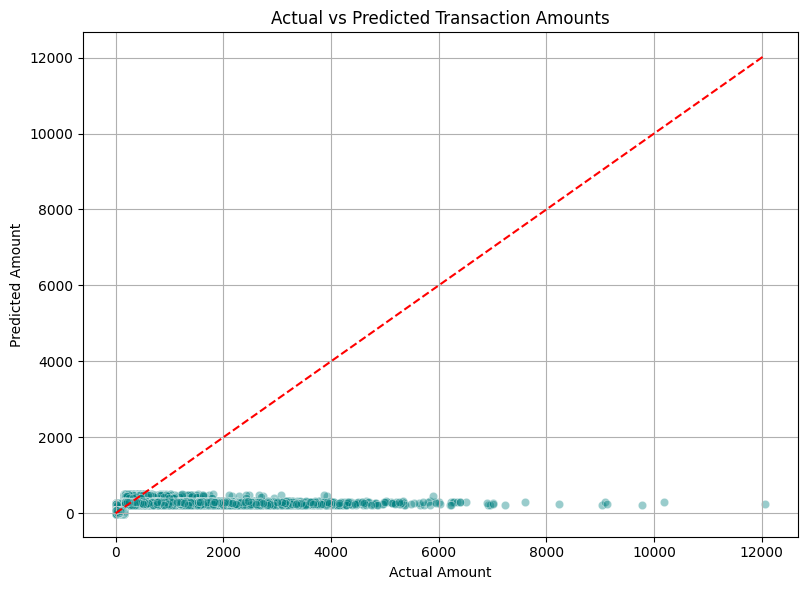

In [9]:
import matplotlib.pyplot as plt

# === Step 8: Visualization ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal', edgecolors='w', linewidth=0.5)
plt.title("Actual vs Predicted Transaction Amounts")
plt.xlabel("Actual Amount")
plt.ylabel("Predicted Amount")
plt.grid(True)
plt.tight_layout()
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.show()

In [10]:
# === Step 8: Identify Key Predictive Features ===
# Get preprocessor and model
preprocessor = pipeline.named_steps["preprocessing"]
model = pipeline.named_steps["model"]

# Feature names
cat_encoded_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = np.concatenate([cat_encoded_names, num_features])

# Coefficients
coefficients = model.coef_
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)
}).sort_values("Abs_Coefficient", ascending=False)

# Display top 10 important features
print("\n🔍 Top 10 Predictive Features:")
print(coef_df[["Feature", "Coefficient"]].head(10))



🔍 Top 10 Predictive Features:
                       Feature  Coefficient
34      location_country_india   131.149800
24      location_country_India   130.955752
46                  risk_score    92.007291
44                        hour    35.282370
36     location_country_mexico   -15.228134
35      location_country_japan   -15.100181
29  location_country_australia   -15.026367
23    location_country_Germany   -14.956969
28        location_country_USA   -14.937831
22     location_country_France   -14.872144


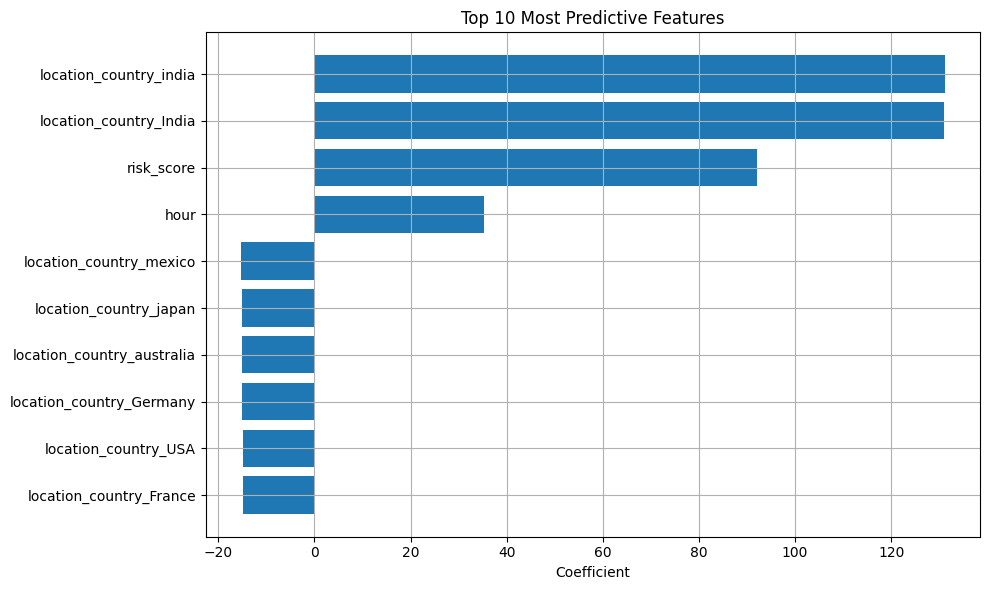

In [11]:
import matplotlib.pyplot as plt

top_n = 10
plt.figure(figsize=(10, 6))
top_features = coef_df.head(top_n)
plt.barh(top_features["Feature"][::-1], top_features["Coefficient"][::-1])
plt.xlabel("Coefficient")
plt.title(f"Top {top_n} Most Predictive Features")
plt.grid(True)
plt.tight_layout()
plt.show()
